# Image Compression for OCR Robustness Study

This notebook compresses PNG screenshots to JPEG format at multiple quality levels to study compression-accuracy tradeoffs in OCR workflows.

## Workflows
- **EXCEL**: Spreadsheet data operations
- **GIT**: GitHub commit/push operations  
- **JIRA**: Ticket creation
- **TEKKEN**: Video game interactions

## Quality Levels
Based on our design decision (see paper Section: Compression Quality Level Selection):
- **50**: Moderate compression (degradation onset)
- **5**: Extreme compression (closest compression level still readable by human eye)
- **1**: Near-incomprehensible compression (close to failure threshold)

**Note**: We use aggressive compression levels (1-50) rather than moderate levels (60-90) because modern image viewers may apply post-processing (sharpening, filtering) that makes compressed images appear clearer than they actually are. Quality level 5 was selected as the closest compression that remains readable by the human eye, while quality 1 approaches incomprehensibility. Using extreme compression ensures we capture the true OCR degradation under realistic viewing conditions.

In [11]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import json

# Configuration
DATA_DIR = Path("data")
QUALITY_LEVELS = [25, 5, 1]  # Aggressive compression levels: 25=moderate, 5=human-readable threshold, 1=maximum compression (lowest possible JPEG quality)
WORKFLOWS = ['EXCEL', 'GIT', 'JIRA', 'TEKKEN']

print("✓ Setup complete!")
print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Quality levels: {QUALITY_LEVELS}")
print(f"Workflows: {WORKFLOWS}")

✓ Setup complete!
Data directory: c:\Users\Matthew Feroz\Desktop\ALIVEOCR\ALIVEData\research\data
Quality levels: [25, 5, 1]
Workflows: ['EXCEL', 'GIT', 'JIRA', 'TEKKEN']


In [12]:
def compress_image(input_path, output_path, quality):
    """
    Compress PNG to JPEG at specified quality.
    
    Args:
        input_path: Path to input PNG file
        output_path: Path to output JPEG file
        quality: JPEG quality (0-100)
    
    Returns:
        Dictionary with compression results
    """
    try:
        img = Image.open(input_path)
        img.load()  # Force loading the image data to ensure it's fully processed
        
        # Convert RGBA to RGB if necessary (JPEG doesn't support transparency)
        if img.mode == 'RGBA':
            rgb_img = Image.new('RGB', img.size, (255, 255, 255))
            rgb_img.paste(img, mask=img.split()[3])  # Use alpha channel as mask
            img = rgb_img
        elif img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Ensure quality is an integer in valid range (1-100)
        quality = max(1, min(100, int(quality)))
        
        # Save as JPEG with specified quality
        # For high quality (90+), use no subsampling; for lower quality, use subsampling
        if quality >= 90:
            img.save(output_path, format='JPEG', quality=quality, optimize=False, subsampling=0)
        else:
            img.save(output_path, format='JPEG', quality=quality, optimize=False, subsampling='4:2:0')
        
        # Return file sizes for analysis
        original_size = os.path.getsize(input_path)
        compressed_size = os.path.getsize(output_path)
        compression_ratio = (1 - compressed_size / original_size) * 100
        
        return {
            'success': True,
            'original_size': original_size,
            'compressed_size': compressed_size,
            'compression_ratio': compression_ratio
        }
    except Exception as e:
        return {'success': False, 'error': str(e)}

In [13]:
# Process all images
results = []

for workflow in WORKFLOWS:
    workflow_dir = DATA_DIR / workflow
    
    if not workflow_dir.exists():
        print(f"⚠ Skipping {workflow} - directory not found")
        continue
    
    print(f"\n{'='*60}")
    print(f"Processing {workflow} workflow")
    print(f"{'='*60}")
    
    png_files = sorted(workflow_dir.glob("*.png"))
    
    if not png_files:
        print(f"  No PNG files found in {workflow}")
        continue
    
    print(f"  Found {len(png_files)} PNG file(s)")
    
    for png_file in png_files:
        base_name = png_file.stem
        print(f"\n  Processing {png_file.name}...")
        
        for quality in QUALITY_LEVELS:
            output_filename = f"{base_name}_q{quality}.jpg"
            output_path = workflow_dir / output_filename
            
            result = compress_image(png_file, output_path, quality)
            
            if result['success']:
                results.append({
                    'workflow': workflow,
                    'image': base_name,
                    'quality': quality,
                    'original_size_mb': result['original_size'] / (1024*1024),
                    'compressed_size_mb': result['compressed_size'] / (1024*1024),
                    'compression_ratio': result['compression_ratio']
                })
                print(f"    ✓ q{quality}: {result['compression_ratio']:.1f}% compression")
            else:
                print(f"    ✗ q{quality}: {result['error']}")

print(f"\n{'='*60}")
print(f"✓ Compression complete! Processed {len(results)} compressed images.")
print(f"{'='*60}")


Processing EXCEL workflow
  Found 4 PNG file(s)

  Processing EXCEL1.png...
    ✓ q25: -9.5% compression
    ✓ q5: 50.6% compression
    ✓ q1: 57.1% compression

  Processing EXCEL2.png...
    ✓ q25: -26.2% compression
    ✓ q5: 42.7% compression
    ✓ q1: 49.5% compression

  Processing EXCEL3.png...
    ✓ q25: -24.8% compression
    ✓ q5: 43.5% compression
    ✓ q1: 50.2% compression

  Processing EXCEL4.png...
    ✓ q25: 16.0% compression
    ✓ q5: 62.0% compression
    ✓ q1: 67.0% compression

Processing GIT workflow
  Found 4 PNG file(s)

  Processing GIT1.png...
    ✓ q25: 99.5% compression
    ✓ q5: 99.6% compression
    ✓ q1: 99.6% compression

  Processing GIT2.png...
    ✓ q25: 99.3% compression
    ✓ q5: 99.5% compression
    ✓ q1: 99.5% compression

  Processing GIT3.png...
    ✓ q25: 99.1% compression
    ✓ q5: 99.4% compression
    ✓ q1: 99.5% compression

  Processing GIT4.png...
    ✓ q25: 99.0% compression
    ✓ q5: 99.4% compression
    ✓ q1: 99.5% compression

Proce

Compression Summary by Workflow and Quality:


compression_ratio  compressed_size_mb
workflow quality                                       
EXCEL    1                    55.96                0.09
         5                    49.71                0.10
         25                  -11.15                0.23
GIT      1                    99.52                0.07
         5                    99.47                0.08
         25                   99.22                0.11
JIRA     1                    60.57                0.07
         5                    57.96                0.07
         25                   40.78                0.10
TEKKEN   1                    98.57                0.07
         5                    98.24                0.09
         25                   96.10                0.19

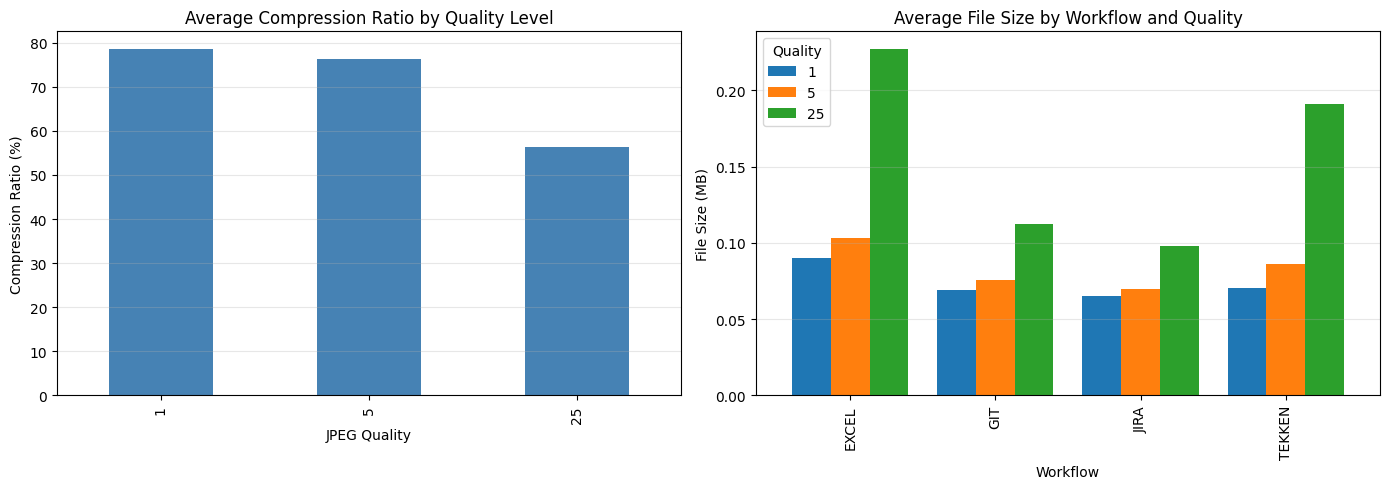

In [14]:
# Create DataFrame and summary
df = pd.DataFrame(results)

if len(df) > 0:
    # Summary table
    summary = df.groupby(['workflow', 'quality']).agg({
        'compression_ratio': 'mean',
        'compressed_size_mb': 'mean'
    }).round(2)
    
    print("Compression Summary by Workflow and Quality:")
    display(summary)
    
    # Plot compression ratios
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Compression ratio by quality
    df.groupby('quality')['compression_ratio'].mean().plot(
        kind='bar', ax=axes[0], color='steelblue'
    )
    axes[0].set_title('Average Compression Ratio by Quality Level')
    axes[0].set_xlabel('JPEG Quality')
    axes[0].set_ylabel('Compression Ratio (%)')
    axes[0].grid(axis='y', alpha=0.3)
    
    # File size comparison
    df_pivot = df.pivot_table(
        values='compressed_size_mb',
        index='workflow',
        columns='quality',
        aggfunc='mean'
    )
    df_pivot.plot(kind='bar', ax=axes[1], width=0.8)
    axes[1].set_title('Average File Size by Workflow and Quality')
    axes[1].set_xlabel('Workflow')
    axes[1].set_ylabel('File Size (MB)')
    axes[1].legend(title='Quality', title_fontsize=10)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to display. Run the compression cell first.")


Showing example from EXCEL:


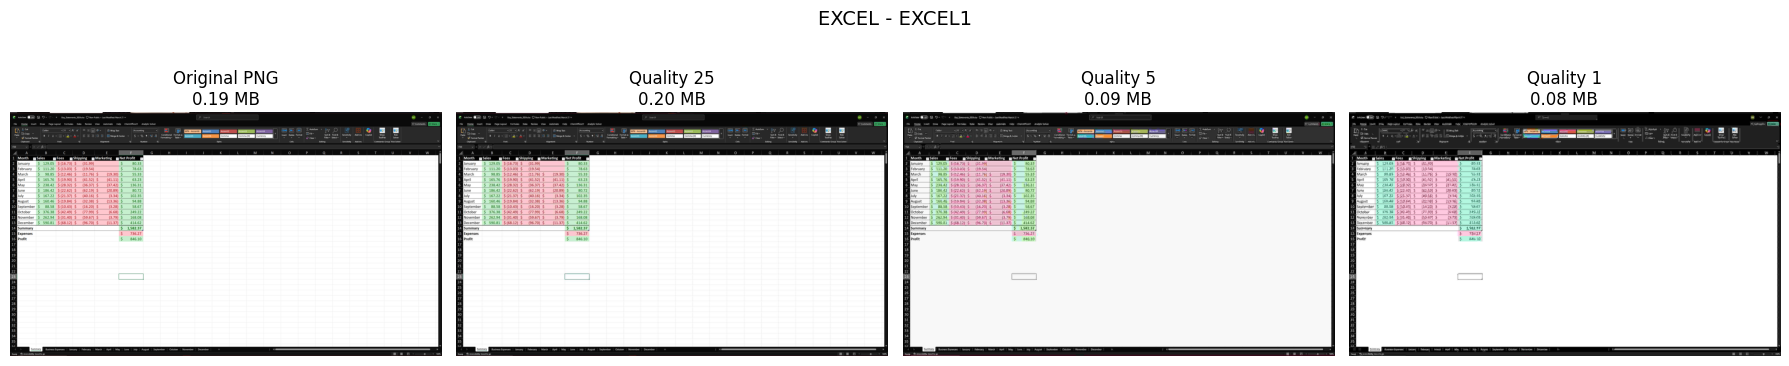

In [15]:
def show_compression_comparison(workflow, image_name):
    """Display original and compressed versions side-by-side."""
    workflow_dir = DATA_DIR / workflow
    original_path = workflow_dir / f"{image_name}.png"
    
    if not original_path.exists():
        print(f"Image not found: {original_path}")
        return
    
    fig, axes = plt.subplots(1, len(QUALITY_LEVELS) + 1, figsize=(18, 4))
    
    # Show original
    img_original = Image.open(original_path)
    axes[0].imshow(img_original)
    axes[0].set_title(f'Original PNG\n{os.path.getsize(original_path)/(1024*1024):.2f} MB')
    axes[0].axis('off')
    
    # Show compressed versions
    for idx, quality in enumerate(QUALITY_LEVELS, 1):
        compressed_path = workflow_dir / f"{image_name}_q{quality}.jpg"
        if compressed_path.exists():
            img_compressed = Image.open(compressed_path)
            axes[idx].imshow(img_compressed)
            size_mb = os.path.getsize(compressed_path)/(1024*1024)
            axes[idx].set_title(f'Quality {quality}\n{size_mb:.2f} MB')
            axes[idx].axis('off')
    
    plt.suptitle(f'{workflow} - {image_name}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Show examples from each workflow
for workflow in WORKFLOWS:
    workflow_dir = DATA_DIR / workflow
    png_files = sorted(workflow_dir.glob("*.png"))
    if png_files:
        print(f"\nShowing example from {workflow}:")
        show_compression_comparison(workflow, png_files[0].stem)
        break  # Show just one example

✓ Loaded 48 rows from compression_results.csv
✓ Generated paper\compression_by_quality.pdf


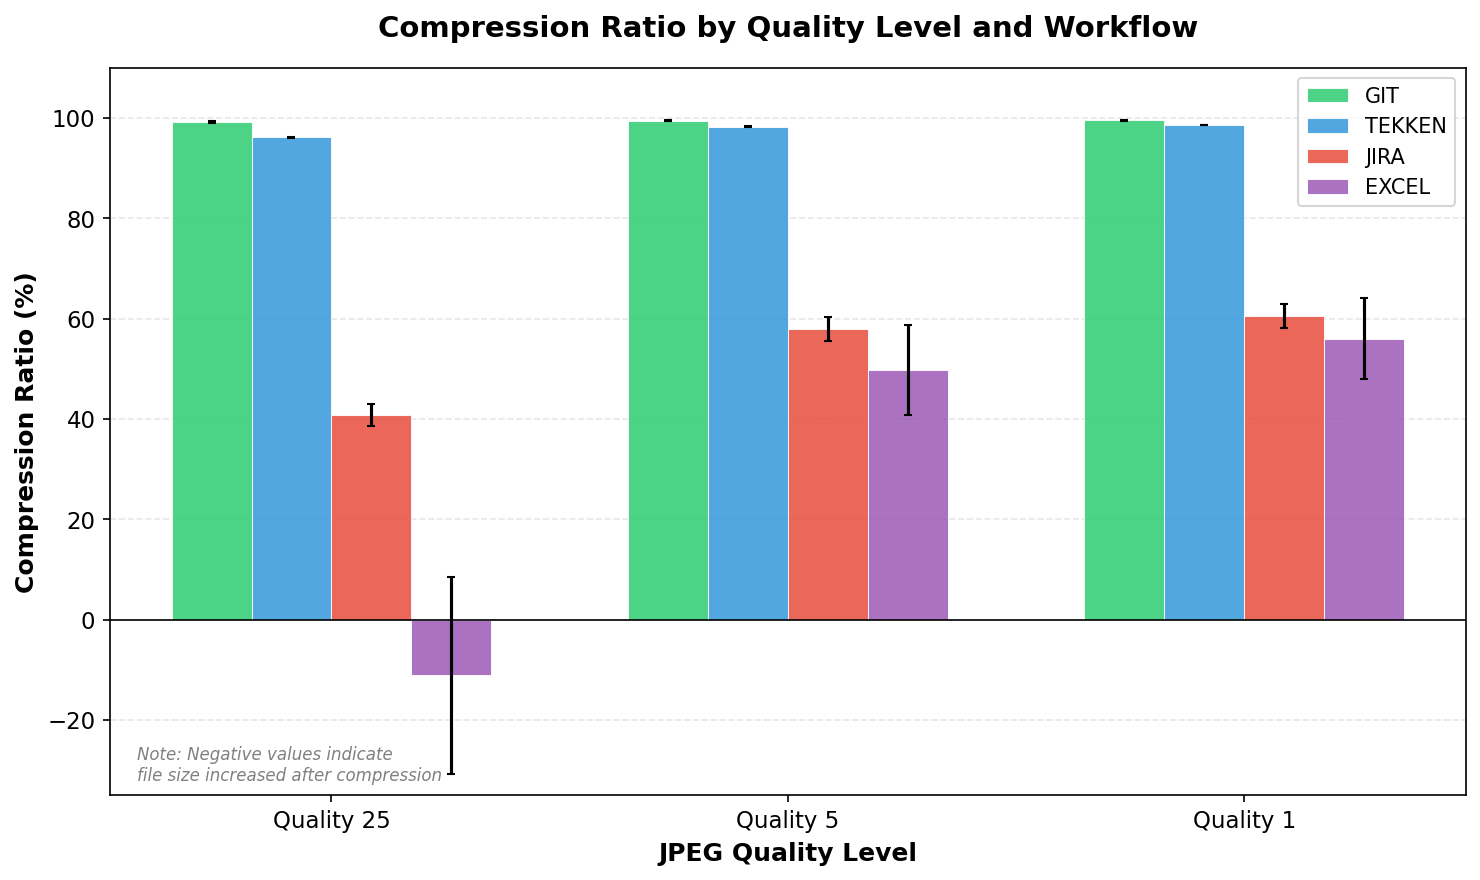

✓ Generated paper\compression_comparison.pdf


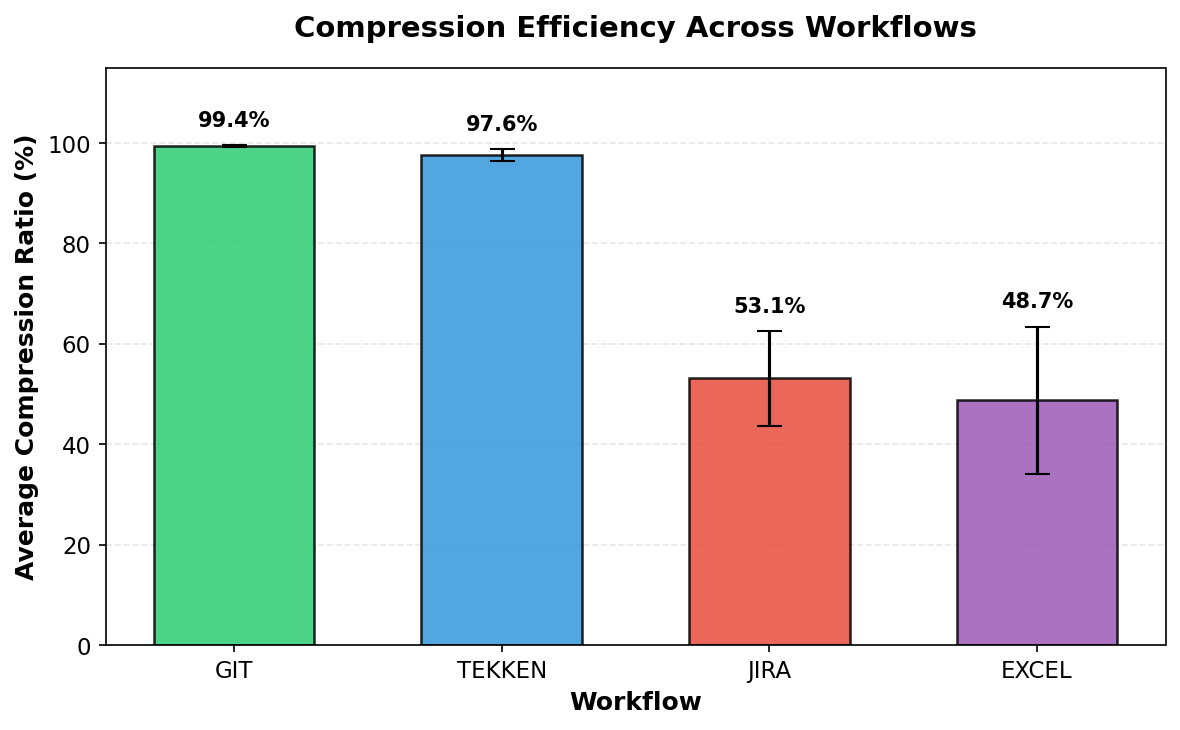


✓ LaTeX-ready figures generated successfully!


In [18]:
# Generate LaTeX-ready figures from compression results
import numpy as np

# Load results from CSV
try:
    df = pd.read_csv('compression_results.csv')
    print(f"✓ Loaded {len(df)} rows from compression_results.csv")
except FileNotFoundError:
    print("⚠ compression_results.csv not found. Run compression cell first.")
    df = None

if df is not None and len(df) > 0:
    # Set up matplotlib for clean figures
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'sans-serif',
        'figure.dpi': 150,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })
    
    paper_dir = Path('paper')
    paper_dir.mkdir(exist_ok=True)
    
    workflows = ['GIT', 'TEKKEN', 'JIRA', 'EXCEL']
    quality_levels = [25, 5, 1]
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']  # Green, Blue, Red, Purple
    
    # ========== Figure 1: Grouped bar chart by quality level ==========
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(quality_levels))
    n_workflows = len(workflows)
    total_width = 0.7  # Total width for all bars in a group
    width = total_width / n_workflows  # Width of each bar
    
    for i, workflow in enumerate(workflows):
        workflow_data = df[df['workflow'] == workflow]
        means = []
        stds = []
        
        for quality in quality_levels:
            quality_data = workflow_data[workflow_data['quality'] == quality]['compression_ratio']
            means.append(quality_data.mean())
            stds.append(quality_data.std())
        
        # Center the bars around each x position
        offset = (i - n_workflows/2 + 0.5) * width
        bars = ax.bar(x + offset, means, width, label=workflow, color=colors[i], 
                      yerr=stds, capsize=2, alpha=0.85, edgecolor='white', linewidth=0.5)
    
    ax.set_xlabel('JPEG Quality Level', fontsize=12, fontweight='bold')
    ax.set_ylabel('Compression Ratio (%)', fontsize=12, fontweight='bold')
    ax.set_title('Compression Ratio by Quality Level and Workflow', fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels([f'Quality {q}' for q in quality_levels], fontsize=11)
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=False, fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
    ax.set_ylim(bottom=-35, top=110)
    ax.axhline(y=0, color='black', linewidth=0.8, zorder=1)  # Zero line
    ax.set_axisbelow(True)
    
    # Add annotation for negative values
    ax.annotate('Note: Negative values indicate\nfile size increased after compression', 
                xy=(0.02, 0.02), xycoords='axes fraction', fontsize=8, 
                style='italic', color='gray')
    
    plt.tight_layout()
    plt.savefig(paper_dir / 'compression_by_quality.pdf', format='pdf')
    print(f"✓ Generated {paper_dir / 'compression_by_quality.pdf'}")
    plt.show()
    
    # ========== Figure 2: Average compression by workflow ==========
    fig, ax = plt.subplots(figsize=(8, 5))
    
    workflow_means = []
    workflow_stds = []
    
    for workflow in workflows:
        workflow_data = df[df['workflow'] == workflow]
        all_ratios = workflow_data['compression_ratio']
        # Filter out negative values for fair comparison
        positive_ratios = all_ratios[all_ratios > 0]
        
        workflow_means.append(positive_ratios.mean())
        workflow_stds.append(positive_ratios.std())
    
    x_pos = np.arange(len(workflows))
    bars = ax.bar(x_pos, workflow_means, color=colors, width=0.6,
                  yerr=workflow_stds, capsize=6, alpha=0.85, 
                  edgecolor='black', linewidth=1.2)
    
    # Add value labels on top of bars
    for i, (bar, mean, std) in enumerate(zip(bars, workflow_means, workflow_stds)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 3,
                f'{mean:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Workflow', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Compression Ratio (%)', fontsize=12, fontweight='bold')
    ax.set_title('Compression Efficiency Across Workflows', fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(workflows, fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
    ax.set_ylim(bottom=0, top=115)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig(paper_dir / 'compression_comparison.pdf', format='pdf')
    print(f"✓ Generated {paper_dir / 'compression_comparison.pdf'}")
    plt.show()
    
    print("\n✓ LaTeX-ready figures generated successfully!")
else:
    print("⚠ No data available to generate figures.")

In [1]:
# Export results to CSV
if len(df) > 0:
    df.to_csv('compression_results.csv', index=False)
    print("✓ Results saved to compression_results.csv")
    print(f"\nTotal images processed: {len(df) // len(QUALITY_LEVELS)}")
    print(f"Total compressed files created: {len(df)}")
    print(f"\nQuality level breakdown:")
    for q in QUALITY_LEVELS:
        count = len(df[df['quality'] == q])
        print(f"  Quality {q}: {count} files")
else:
    print("No results to export.")

NameError: name 'df' is not defined